# Importing libraries

In [29]:
import pandas as pd
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 100)

from pysus.online_data import SIH
from optimizedf.optimize_df import optimize_df

from IPython.display import display, clear_output

import time
import logging
import itertools
import wget

import numpy as np
import os

# import dask.dataframe as dd
import pickle

import random
from zipfile import ZipFile
import re
from dbfread import DBF

import warnings
warnings.filterwarnings('ignore')

# from utils.utils import make_weekly_graph, make_daily_int_each_month
# # from utils.readdbc import read_dbc
# from utils.IBGETools import pop_ibge
# from utils.HematoTools import make_all_dataset, download_layout, make_maps

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

# Preparing data <a name='prepare_data'></a>

## Loading DataFrame and maps

In [30]:
LIST_CID = ['D46', 'D461', 'D462', 'D463', 'D464', 'D467', 'D469', 
            'C81', 'C810', 'C811', 'C812', 'C813', 'C817', 'C819', 
            'B212', 
            'C82', 'C820', 'C821', 'C822', 'C827', 'C829',
            'C83', 'C830', 'C831', 'C832', 'C833', 'C834', 'C835', 'C836', 'C837', 'C838', 'C839',
            'C84', 'C840', 'C841', 'C842', 'C843', 'C844', 'C845',
            'C85', 'C850', 'C851', 'C857', 'C859',
            'C88', 'C880', 'C881', 'C882', 'C883', 'C887', 'C889', 'C963',
            'C91', 'C910', 'C911', 'C912', 'C913', 'C914', 'C915', 'C917', 'C919',
            'C92', 'C920', 'C921', 'C922', 'C923', 'C924', 'C927', 'C929',
            'C93', 'C930', 'C931', 'C932', 'C937', 'C939',
            'C94', 'C940', 'C941', 'C942', 'C943', 'C944', 'C945', 'C947',
            'C95', 'C950', 'C951', 'C952', 'C957', 'C959',
            'C90', 'C900', 'C901', 'C902']

In [31]:
months = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

In [32]:
ufs = ['AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MT',
          'MS', 'MG', 'PA', 'PB', 'PR', 'PE', 'PI', 'RJ', 'RN', 'RS', 'RO',
          'RR', 'SC', 'SP', 'SE', 'TO']

In [33]:
COLS = 'N_AIH UF_ZI DT_INTER DT_SAIDA US_TOT DIAS_PERM ANO_CMPT DIAG_PRINC MORTE IDADE CNES\
        SEXO ETNIA COMPLEX CAR_INT MUNIC_RES MUNIC_MOV NASC'.split()

In [34]:
def download_all(job=None):
    tic = time.time()
    for i in itertools.product(range(2008, 2018), ufs, range(1, 13)):
        year, uf, month = i
        try:
            clear_output()
            display(('Downloading', uf, month, year))
            display(('Time elapsed', time.time() - tic))
            df = SIH.download(uf, year, month)
            job(df)
        except Exception as e:
            make_log(e, uf, month, year)

def make_log(e, uf, month, year):
    logging.basicConfig(filename='errors.log',level=logging.DEBUG)
    logging.time.localtime()
    logging.exception(e)
    logging.debug('Error on {} {} {}'.format(uf, month, year))
    
# download_all() # uncomment to download all files

In [35]:
def make_hemato_ds():
    tic = time.time()
    all_df = pd.DataFrame()
    
    for i in itertools.product(range(2008, 2018), ufs, range(1, 13)):
        year, uf, month = i
        try:
            clear_output(wait=True)
            display(('processing', uf, month, year))
            display(('Time elapsed', time.time() - tic))
            df = SIH.download(uf, year, month)
            df = df[COLS]
            df = df[df['DIAG_PRINC'].isin(LIST_CID)]
            df['ETNIA'] = df['ETNIA'].fillna('0000')
            df.UF_ZI = df.UF_ZI.str[:2]
            all_df = all_df.append(df, ignore_index=True)
        except Exception as e:
            make_log(e, uf, month, year)
    
    all_df.to_parquet('all_hemato.parquet')

# make_hemato_ds() # uncomment to fetch a new hemato ds

In [36]:
# evolução mortalidade por ano, por doença, por uf
# histograma/media idade por ano, por doença, por estado
# numero de internações por ano, por doença, por estado
# histograma/media/boxplot custo por ano, por doença, por estado

In [37]:
PRODUCED_DATASETS = 'files'

def download_zip(url, force_download=False, prefix=None):
    '''
    Download TAB_SIH.zip and save in cache.
    
    Returns
    -------
        local path to the downloaded file
    '''
    if prefix != None:
        filename = '{}_'.format(prefix) + wget.detect_filename(url)
        print('filename', filename)
    else:
        filename = wget.detect_filename(url)

    local_file = os.path.join(PRODUCED_DATASETS, filename)
    if not os.path.exists(local_file) or force_download:
        wget.download(url, local_file)
    return local_file


def download_layout(force_download=False):
    '''
    Download the PDF with the layout of the data and save it in the local folder.
    '''
    url = 'ftp://ftp.datasus.gov.br/dissemin/publicos/SIHSUS/200801_/Doc/IT_SIHSUS_1603.pdf'
    filename = wget.detect_filename(url)
    if not os.path.exists(filename) or force_download:
        wget.download(url, filename)
    

def make_maps(force_download=False):
    
    CID_URL = 'http://www.datasus.gov.br/cid10/V2008/downloads/CID10CSV.zip'
    local_zipfile = download_zip(CID_URL, force_download)
    with ZipFile(local_zipfile) as zfile:
        l = zfile.namelist()
        
        with zfile.open('CID-10-SUBCATEGORIAS.CSV') as cid_file:
            cid_map = pd.read_csv(cid_file, sep=';', encoding='iso-8859-1', usecols=['SUBCAT', 'DESCRICAO'],
                                 index_col='SUBCAT', squeeze=True)

    
    TAB_SIH_URL = 'ftp://ftp.datasus.gov.br/dissemin/publicos/SIHSUS/200801_/Auxiliar/TAB_SIH.zip'
    local_zipfile = download_zip(TAB_SIH_URL, force_download)
    with ZipFile(local_zipfile) as zfile:
        l = zfile.namelist()
        
        # br_municip.cnv
        with zfile.open('br_municip.cnv') as file:
            mun_map = pd.read_table(file, sep=b'\s{2,}', engine='python', encoding='iso-8859-1',
                                   skiprows=1, header=None, skipfooter=3).applymap(func_decode)
            mun_map[1] = mun_map[1].str.split(' ', 1).str.get(1)
            mun_map = pd.Series(mun_map[1].tolist(), index=mun_map[2].tolist())
            for i, mun in mun_map[mun_map.str.startswith('Município')].items():
                for i2 in i.split(','):
                    mun_map[str(i2).zfill(6)] = mun
                mun_map.drop(i, inplace=True)
            mun_map = mun_map.to_dict()
            for i in ['520000', '529999']:
                mun_map[i] = 'Município ignorado - GO'

            list_brasilia = []
            for i in range(530000, 530009 + 1):
                list_brasilia.append(str(i))
            for i in range(530011, 539999 + 1):
                list_brasilia.append(str(i))
            list_brasilia.append('530010')

            for i in list_brasilia:
                mun_map[i] = 'Brasília'

            list_ign = []
            for i in range(1, 9999):
                list_ign.append(str(i).zfill(6))

            list_ign = list_ign + ['000000', '999999']
            for i in list_ign:
                mun_map[i] = 'Ignorado ou exterior'

        # CARATEND.CNV
        with zfile.open('CARATEND.CNV') as file:
            caratend_map = pd.read_table(file, sep=b'\s{2,}', engine='python', encoding='iso-8859-1',
                                       skiprows=1, header=None).applymap(func_decode)
            caratend_map = { '01': 'Eletivo',
                             '02': 'Urgência',
                             '03': 'Acidente no local trabalho ou a serv da empresa',
                             '04': 'Acidente no trajeto para o trabalho',
                             '05': 'Outros tipo de acidente de trânsito',
                             '06': 'Out tp lesões e envenen por agent quím físicos'}
            #fiz manualmente porque não funcionou o encoding e o decode
    
        
        # COMPLEX2.CNV
        with zfile.open('COMPLEX2.CNV') as file:
            comp_map = pd.read_table(file, sep=b'\s{2,}', engine='python', encoding='iso-8859-1',
                                       skiprows=1, header=None).applymap(func_decode)
            comp_map = {'00': 'Não se aplica',
                        '01': 'Atenção básica',
                        '02': 'Média complexidade',
                        '03': 'Alta complexidade',
                        '99': 'Não se aplica'}
            #fiz manualmente porque não funcionou o encoding e o decode
    
        # FINANC.CNV
        with zfile.open('FINANC.CNV') as file:
            df = pd.read_table(file, sep=b'\s{2,}', engine='python', encoding='iso-8859-1',
                                   skiprows=1, header=None).applymap(func_decode)
            temp = pd.DataFrame([{1:'Não discriminado', 2:'00'}, {1:'Não discriminado', 2:'99'},
                                 {1:'04 Fundo de Ações Estratégicas e Compensações FAEC', 2:'04'}])
            df = pd.concat([df, temp], ignore_index=True).drop(0, axis=1).drop([0, 3])
            financ_map = pd.Series(df[1].tolist(), index=df[2].tolist())
        
        # ETNIA
        with zfile.open('etnia.cnv') as et_file:
            df_et = pd.read_table(et_file, sep=b'\s{2,}', engine='python', encoding='iso-8859-1',
                                   skiprows=1, header=None).applymap(func_decode)
            ni = pd.DataFrame([{1:'NÃO INFORMADO', 2:'0000'}, {1:'NÃO INFORMADO', 2:'9999'}])
            df_et = pd.concat([df_et, ni], ignore_index=True).drop(0, axis=1).drop(0)
            et_map = pd.Series(df_et[1].tolist(), df_et[2].tolist())
    
        # SEX
        with zfile.open('SEXO.CNV') as sex_file:
            df = pd.read_table(sex_file, sep=b'\s{2,}', engine='python',
                               skiprows=1, header=None).applymap(func_decode)
            sex_map = {df.loc[0, 2][0]: df.loc[0, 1],
                       df.loc[0, 2][2]: df.loc[0, 1],
                       df.loc[1, 2]:    df.loc[1, 1],
                       df.loc[2, 2][0]: df.loc[2, 1],
                       df.loc[2, 2][2]: df.loc[2, 1]}

        # UF
        with zfile.open('br_ufsigla.cnv') as uf:
            df = pd.read_table(uf, sep=b'\s{2,}', engine='python',
                               skiprows=1, header=None).applymap(func_decode).dropna(axis=1)
            pe = pd.DataFrame([{1:'PE', 2:'20'}, {1:'PE', 2:'26'}])
            df = pd.concat([df, pe], ignore_index=True)
            df.drop(12, inplace=True)
            uf_map = pd.Series(df[1].tolist(), df[2].tolist())
            
        # CNES
        list_df = []
        list_cnes = [item for item in l if re.search('\S+CNES\S+', item)]
        for file in list_cnes:
            zfile.extract(file)
            dbf = DBF(file, encoding='utf-8')
            cnes_temp = pd.DataFrame(list(dbf))
            list_df.append(cnes_temp)
            os.unlink(file)
        cnes_br = pd.concat(list_df, sort=False).drop_duplicates()
        cnes_br['UF_ZI'] = cnes_br.UF_ZI.map(uf_map)
        cnes_map = pd.Series(cnes_br.NOMEFANT.tolist(), index=cnes_br.CNES.tolist())
    
        # CBO.dbf
        file = 'CBO.dbf'
        zfile.extract(file)
        dbf = DBF(file, encoding='iso-8859-1')
        cbo_map = pd.DataFrame(list(dbf))
        cbo_map = pd.Series(cbo_map.DS_CBO.tolist(), index=cbo_map.CBO.tolist())
        os.unlink(file)
        
    
    
    return sex_map, cnes_map, uf_map, cid_map, et_map, financ_map, cbo_map, comp_map, mun_map, caratend_map


def func_decode(x):
    if type(x) == bytes:
        try:
            return x.decode()
        except UnicodeDecodeError:
            return x.decode(encoding='iso-8859-1')

In [38]:
sex_map, cnes_map, uf_map, cid_map, et_map, \
financ_map, cbo_map, comp_map, mun_map, caratend_map = make_maps()

In [39]:
def pop_2010(force_download=False):
    '''
    I didn't find the 2010's data, had to make the dataset by myself.
    '''
    parent_path = 'ftp://ftp.ibge.gov.br/Censos/Censo_Demografico_2010/resultados/'
    list_files = ["total_populacao_acre.zip","total_populacao_alagoas.zip","total_populacao_amapa.zip",
                "total_populacao_amazonas.zip", "total_populacao_bahia.zip", "total_populacao_ceara.zip", 
                "total_populacao_distrito_federal.zip", "total_populacao_espirito_santo.zip", 
                "total_populacao_goias.zip", "total_populacao_maranhao.zip","total_populacao_mato_grosso.zip",
                "total_populacao_mato_grosso_do_sul.zip","total_populacao_minas_gerais.zip",
                "total_populacao_para.zip",
                "total_populacao_paraiba.zip","total_populacao_parana.zip","total_populacao_pernambuco.zip",
                "total_populacao_piaui.zip","total_populacao_rio_de_janeiro.zip",
                "total_populacao_rio_grande_do_norte.zip",
                "total_populacao_rio_grande_do_sul.zip","total_populacao_rondonia.zip",
                "total_populacao_roraima.zip",
                "total_populacao_santa_catarina.zip","total_populacao_sao_paulo.zip",
                "total_populacao_sergipe.zip",
                "total_populacao_tocantins.zip"]
    states = ['AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MT',
              'MS', 'MG', 'PA', 'PB', 'PR', 'PE', 'PI', 'RJ', 'RN', 'RS', 'RO',
              'RR', 'SC', 'SP', 'SE', 'TO']

    filename_2010 = '2010_UF_Municipio.parquet'
    local_file_2010 = os.path.join(PRODUCED_DATASETS, filename_2010)
    
    if not os.path.exists(local_file_2010):
        list_df = []
        for file, uf in zip(list_files, states):
            path = parent_path + file
            local_path = os.path.join(PRODUCED_DATASETS, file)
            if not os.path.exists(local_path):
                wget.download(path, local_path)
            with ZipFile(local_path) as zfile:
                file = zfile.namelist()[0]
                with zfile.open(file) as xls_file:
                    temp_df = pd.read_excel(xls_file)
                    temp_df = temp_df[['Nome do município', 'Total da população 2010']]
                    temp_df.columns = ['NOME', '2010']
                    temp_df.NOME = temp_df.NOME + ' ({})'.format(uf)
                    temp_df['SIGLA'] = uf
                    list_df.append(temp_df)
        df = pd.concat(list_df, sort=False, ignore_index=True).dropna()
        df.to_parquet(local_file_2010)
    else:
        df = pd.read_parquet(local_file_2010)
    
    df['2010'] = df['2010'].astype(int)
    return df[['SIGLA', 'NOME', '2010']]

def _2008(year=2008):
    path = 'ftp://ftp.ibge.gov.br/Estimativas_de_Populacao/Estimativas_{}/UF_Municipio.zip'.format(year)
    
    local_path = os.path.join(PRODUCED_DATASETS, '{}_UF_Municipio.zip'.format(year))
    if not os.path.exists(local_path):
        wget.download(path, local_path)
    with ZipFile(local_path) as zfile:
        file = zfile.namelist()[0]
        with zfile.open(file) as xls_file:
            pop = pd.read_excel(xls_file, skiprows=4).dropna()
            pop.columns = ['SIGLA', 'COD', 'COD.1', 'NOME', '{}'.format(year)]
            pop.drop(['COD', 'COD.1'], axis=1, inplace=True)
            pop.NOME = pop.NOME + ' (' + pop.SIGLA + ')'
    if year != 2009:
        pop['{}'.format(year)] = pop['{}'.format(year)].astype(int)
    return pop

def _2009(year=2009):
    df = _2008(year)
    df.drop(289, inplace=True)
    df['2009'] = df['2009'].astype(int)
    return df

def _2010(year=2010):
    return pop_2010()

def _2011(year=2011):
    return _2008(year)

def _2012(year=2012,
          path = 'ftp://ftp.ibge.gov.br/Estimativas_de_Populacao/Estimativas_2012/',
          filename = 'estimativa_2012_DOU_28_08_2012_xls.zip',
          skip=2):
    
    local_path = os.path.join(PRODUCED_DATASETS, filename)
    if not os.path.exists(local_path):
        wget.download(path + filename, local_path)
    
    with ZipFile(local_path) as zfile:
        file = zfile.namelist()[0]
        with zfile.open(file) as xls_file:
            df = pd.read_excel(xls_file, skiprows=skip, encoding='utf-8').dropna()
            df.columns = ['SIGLA', 'COD', 'COD.1', 'NOME', '{}'.format(year)]
            df.drop(['COD', 'COD.1'], axis=1, inplace=True)
            df.NOME = df.NOME + ' (' + df.SIGLA + ')'
    
    if year == 2012:
        year = '{}'.format(2012)
        mask = df[year].str.startswith('(*)', na=False)
        df.loc[mask, year] = df.loc[mask, year].str[3:]#.replace('.', '')
        df.loc[mask, year] = df.loc[mask, year].str.replace('.', '')
        df[year] = df[year].astype(int)
    return df

        
def _2013(year=2013):
    path = 'ftp://ftp.ibge.gov.br/Estimativas_de_Populacao/Estimativas_2013/'
    filename = 'estimativa_2013_dou_xls.zip'
    df = _2012(2013, path, filename)
    df['2013'] = df['2013'].astype(int)
    return df


def _2014(year=2014):
    path = 'ftp://ftp.ibge.gov.br/Estimativas_de_Populacao/Estimativas_2014/'
    filename = 'estimativa_dou_2014_xls.zip'
    
    local_path = os.path.join(PRODUCED_DATASETS, filename)
    if not os.path.exists(local_path):
        wget.download(path + filename, local_path)

    with ZipFile(local_path) as zfile:
        file = zfile.namelist()[0]
        with zfile.open(file) as xls_file:
            pop = pd.read_excel(xls_file, sheet_name='Municípios', skiprows=2).dropna()
            pop.columns = ['SIGLA', 'COD', 'COD.1', 'NOME', '{}'.format(year)]
            pop.drop(['COD', 'COD.1'], axis=1, inplace=True)
            pop.NOME = pop.NOME + ' (' + pop.SIGLA + ')'
    
    pop.loc[210, '2014'] = 41487
    pop['2014'] = pop['2014'].astype(int)
    return pop

        
def _2015(year=2015,
          path = 'ftp://ftp.ibge.gov.br/Estimativas_de_Populacao/Estimativas_2015/',
          filename = 'estimativa_dou_2015_20150915.xls',
          skip=2):
    
    local_path = os.path.join(PRODUCED_DATASETS, filename)
    if not os.path.exists(local_path):
        wget.download(path + filename, local_path)
    pop = pd.read_excel(local_path, sheet_name='Municípios', skiprows=skip).dropna()
    pop.columns = ['SIGLA', 'COD', 'COD.1', 'NOME', '{}'.format(year)]
    pop.drop(['COD', 'COD.1'], axis=1, inplace=True)
    pop.NOME = pop.NOME + ' (' + pop.SIGLA + ')'

    y = '{}'.format(year)
    pop.loc[210, y] = 41487
    
    if year == 2015:
        pop[y] = pop[y].astype(int)
    
    return pop

def _2016(year=2016):
    path = 'ftp://ftp.ibge.gov.br/Estimativas_de_Populacao/Estimativas_2016/'
    filename = 'estimativa_dou_2016_20160913.xlsx'
    df = _2015(2016, path, filename)
    mask = df['2016'].str.endswith('(2)', na=False)
    df.loc[mask, '2016'] = df[mask]['2016'].str[:-3]
    df['2016'] = df['2016'].astype(int)
    return df

def _2017(year=2017):
    path = 'ftp://ftp.ibge.gov.br/Estimativas_de_Populacao/Estimativas_2017/'
    filename = 'estimativa_dou_2017.xls'
    df = _2015(2017, path, filename, 1)
    for end in ['(1)', '(3)', '(4)', '(5)']:
        mask = df['2017'].str.endswith(end, na=False)
        df.loc[mask, '2017'] = df.loc[mask, '2017'].str[:-3]
    df['2017'] = df['2017'].astype(int)
    return df

def _2018(year=2018):
    path = 'ftp://ftp.ibge.gov.br/Estimativas_de_Populacao/Estimativas_2018/'
    filename = 'estimativa_dou_2018_20181019.xls'
    df = _2015(2018, path, filename, 1)
    year = '{}'.format(year)
    for end in range(1, 15):
        mask = df[year].str.endswith('({})'.format(end), na=False)
        df.loc[mask, year] = df.loc[mask, year].str[:-4]
        df.loc[mask, year] = df.loc[mask, year].str.replace('.', '')
    df[year] = df[year].astype(int)
    return df



def pop_ibge():
    df = _2008().merge(_2009())
    df = df.merge(_2010())
    df = df.merge(_2011())
    df = df.merge(_2012())
    df = df.merge(_2013())
    df = df.merge(_2014())
    df = df.merge(_2015())
    df = df.merge(_2016())
    df = df.merge(_2017())
    df = df.merge(_2018())
    df.drop([289, 3220, 3809, 5385], inplace=True)
    return df

In [40]:
pop_df = pop_ibge()

In [41]:
hemato = pd.read_parquet('all_hemato.parquet')
opt_cols = optimize_df(hemato)
hemato = hemato.astype(opt_cols)

hemato.head()

Optimizing df...

Original df size: Total memory usage: 435.46 MB
Optimized df size: Total memory usage: 52.20 MB


,N_AIH,UF_ZI,DT_INTER,DT_SAIDA,US_TOT,DIAS_PERM,ANO_CMPT,DIAG_PRINC,MORTE,IDADE,CNES,SEXO,ETNIA,COMPLEX,CAR_INT,MUNIC_RES,MUNIC_MOV,NASC
0,1208100045009,12,20080116,20080121,186.720001,5,2008,C917,0,23,2001586,1,,02,01,120050,120040,19841009
1,1208100040873,12,20071211,20071221,186.720001,10,2008,C920,0,20,2001586,1,,02,01,120040,120040,19870714
2,1208100116729,12,20080129,20080315,606.570007,46,2008,C910,0,42,2001586,3,,03,01,120010,120040,19650425
3,1208100241843,12,20080529,20080629,1297.079956,31,2008,C921,1,55,5336171,1,,02,02,120020,120020,19520731
4,1208100202859,12,20080430,20080604,919.210022,35,2008,C959,1,72,2001586,3,,03,01,120040,120040,19350522


In [42]:
hemato.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500576 entries, 0 to 500575
Data columns (total 18 columns):
N_AIH         500576 non-null object
UF_ZI         500576 non-null category
DT_INTER      500576 non-null category
DT_SAIDA      500576 non-null category
US_TOT        500576 non-null float32
DIAS_PERM     500576 non-null uint16
ANO_CMPT      500576 non-null category
DIAG_PRINC    500576 non-null category
MORTE         500576 non-null uint8
IDADE         500576 non-null uint8
CNES          500576 non-null category
SEXO          500576 non-null category
ETNIA         500576 non-null category
COMPLEX       500576 non-null category
CAR_INT       500576 non-null category
MUNIC_RES     500576 non-null category
MUNIC_MOV     500576 non-null category
NASC          500576 non-null category
dtypes: category(13), float32(1), object(1), uint16(1), uint8(2)
memory usage: 52.2 MB


# Exploratory Data Analisys

## Usando todos os dados:

### Internações por ano:

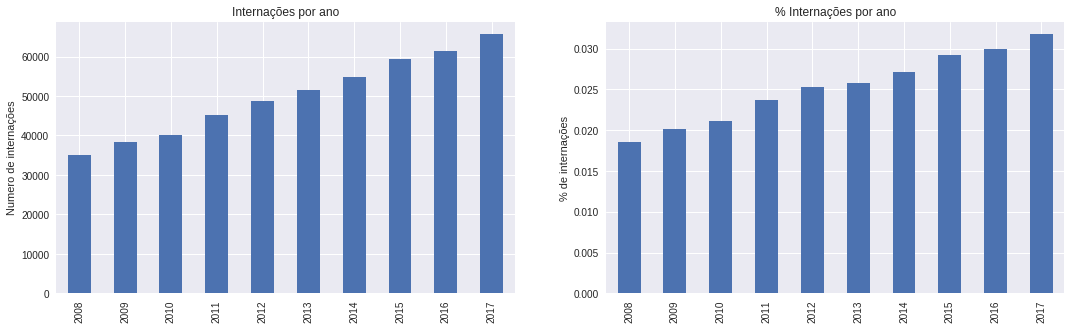

In [18]:
def plot_internações_por_ano():
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    fig.subplots_adjust(
        right=1,
        left=0
                       )
    hemato.ANO_CMPT.value_counts().sort_index().plot(kind='bar', title='Internações por ano',
                                                     ax=ax[0])
    ax[0].set_ylabel('Numero de internações')

    pop_total = pop_df.groupby('SIGLA').sum().sum()[:-1]
    int_ano = hemato.groupby('ANO_CMPT').N_AIH.count()
    (int_ano * 100 / pop_total).plot(kind='bar', title='% Internações por ano',
                                     ax=ax[1])
    ax[1].set_ylabel('% de internações')
    ax[1].set_xlabel('')
    plt.savefig('images/int_each_year.png')
    plt.show()
    
plot_internações_por_ano()

### Internações por sexo:

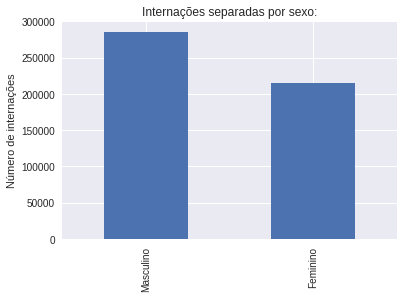

In [19]:
# TODO: comparar o percentual de internações em cada sexo, já que há mais mulheres do que homens

hemato.SEXO.map(sex_map).value_counts().plot(kind='bar')
plt.title('Internações separadas por sexo:')
plt.ylabel('Número de internações')
plt.savefig('images/int_sexo.png')
plt.show()

### Valor total recebido por AIH:

A escala é logarítmica por causa da amplitude dos valores.

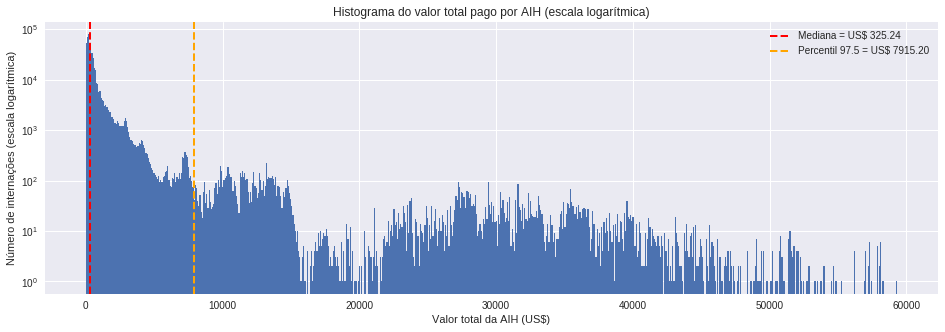

In [20]:
hemato.US_TOT.hist(log=True, bins=int(np.sqrt(len(hemato))), figsize=(16, 5))
median = hemato.US_TOT.quantile(.5)

q = .975
p = hemato.US_TOT.quantile(q)
plt.axvline(x=median, color='r', linestyle='--', linewidth=2, label='Mediana = US$ {:.2f}'.format(median))
plt.axvline(x=p, color='orange', linestyle='--', linewidth=2,
            label='Percentil {:.1f} = US$ {:.2f}'.format(q * 100, p))

plt.xlabel('Valor total da AIH (US$)')
plt.ylabel('Número de internações (escala logarítmica)')
plt.legend(loc=1)
plt.title('Histograma do valor total pago por AIH (escala logarítmica)')
plt.savefig('images/histogram_us_tot.png')
plt.show()

#### Swarmplot

- Too much data, too much time consuming (almost 7 sec with just 0.1% of the data. Probably about 2h to all the data.)
- Not very informative

In [21]:
# %%time
# _ = sns.swarmplot('SEXO', 'US_TOT', data=hemato.sample(frac=.001))
# _ = plt.xlabel('Sexo')
# _ = plt.xticks([0, 1], labels=['Masculino', 'Feminino'])
# _ = plt.ylabel('Valor pago por AIH (US$)')
# _ = plt.title('Valor pago por AIH, separado por sexo:')
# plt.show()

#### Empirical cumulative distribution function:

- Confirmando estatisticamente a distribuição exponencial dos valores.
- 97,5% das internações recebem menos de US$ 3053,00

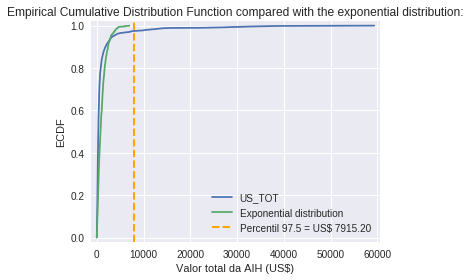

In [22]:
from statsmodels.distributions.empirical_distribution import ECDF

ecdf = ECDF(hemato.US_TOT)

mean = hemato.US_TOT.mean()

sample = np.random.exponential(mean, 1000)
cdf_sample = ECDF(sample)

q = .975
p = hemato.US_TOT.quantile(q)

plt.plot(ecdf.x, ecdf.y, label='US_TOT')
plt.plot(cdf_sample.x, cdf_sample.y, label='Exponential distribution')
plt.axvline(x=p, color='orange', linestyle='--', linewidth=2,
            label='Percentil {:.1f} = US$ {:.2f}'.format(q * 100, p))
plt.legend()
plt.xlabel('Valor total da AIH (US$)')
plt.ylabel('ECDF')
plt.title('Empirical Cumulative Distribution Function compared with the exponential distribution:')
plt.tight_layout()
plt.margins(.02)
plt.savefig('images/ecdf_us_tot.png')
plt.show()

# a US_TOT tem distribuição exponencial

#### Boxplot da distribuição dos valores pagos por AIH
- O valor mínimo pago foi US$ 5,02 

- 4 AIH receberam US\$ 0,00 

- pouco mais de 2% das AIHs recebem menos de US$ 21,00

- 25% receberam menos de US$ 120,00

- metade das AIHs recebeu entre US\\$ 120,00 e US$ 360,00

- menos de 2,5% receberam mais de US\\$ 3000,00

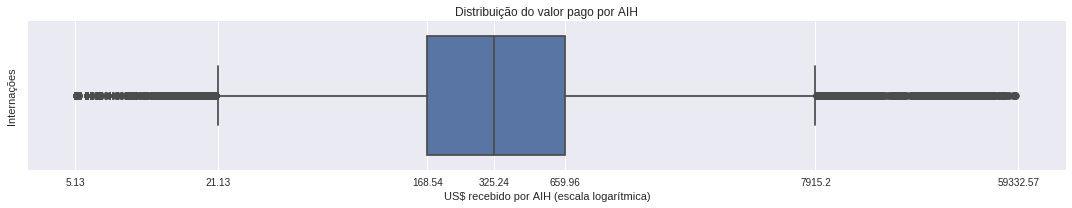

In [23]:
percentiles = np.percentile(hemato.US_TOT, [2.25, 25, 50, 75, 97.5]) #np.mean(hemato.US_TOT)
min_, max_ = hemato.US_TOT[hemato.US_TOT > 0].min(), hemato.US_TOT.max()

avg = hemato.US_TOT.mean()
std = hemato.US_TOT.std()

ticks = np.round([min_, *percentiles, max_], 2)

_ = plt.figure(figsize=(15, 3))
_ = sns.boxplot(y = np.log10(hemato.US_TOT.values), orient='h', whis=[2.25, 97.5])
_ = plt.xlabel('US$ recebido por AIH (escala logarítmica)')
_ = plt.ylabel('Internações')
_ = plt.title('Distribuição do valor pago por AIH')
_ = plt.xticks(np.log10(ticks), ticks)#[1, 2, 3, 4, 5], np.power(10, [1, 2, 3, 4, 5]))
plt.savefig('images/boxplot_us_tot.png')
plt.tight_layout()
plt.show()

* 4 AIH receberam US\$ 0,00 

### Evolução do total de internações absolutas no período:

* Claramente aumentou o número absoluto
* Parece que as vezes a velocidade de crescimento diminui um pouco no inverno com picos em fevereiro

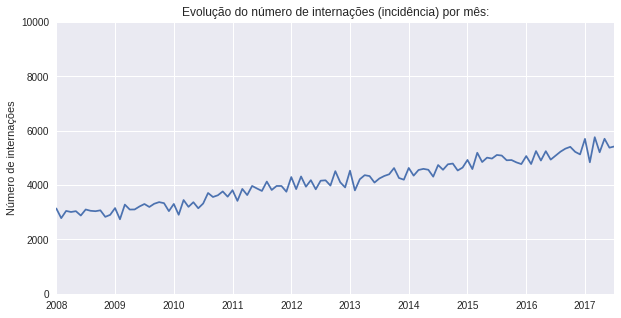

In [24]:
# TODO: ver a população a cada ano e ver se aumentou o percentual de internações hemato

int_by_day = pd.to_datetime(hemato.DT_INTER).value_counts()

int_by_day['2008':'2018'].resample('M').sum()[:-5].plot(figsize=(10, 5),
                                                        ylim=(0, 10000))
plt.title('Evolução do número de internações (incidência) por mês:')
plt.ylabel('Número de internações')
plt.show()

### Evolução da média de internações no ano anterior:

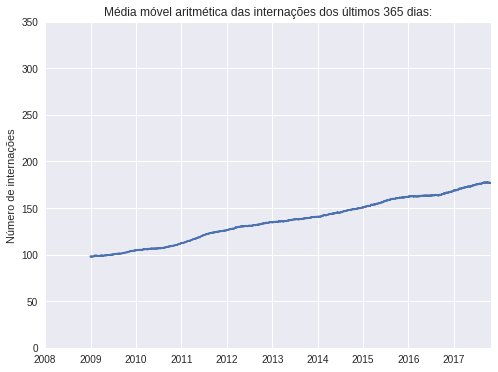

(cada ponto é a média das internações dos últimos 365 dias)


In [25]:
int_by_day['2008':'2018'].resample('D').sum().rolling(365).mean()[:-60].plot(figsize=(8, 6),
                                                                             ylim=(0, 350))
plt.title('Média móvel aritmética das internações dos últimos 365 dias:')
plt.ylabel('Número de internações')
plt.show()
print('(cada ponto é a média das internações dos últimos 365 dias)')

In [27]:
def make_daily_int_each_month(hemato):

    pivoted = hemato.pivot_table('N_AIH', index=hemato.DT_INTER.dt.day, columns=hemato.DT_INTER.dt.month,
                                 aggfunc='count')

    pivoted.columns.name = None
    pivoted.columns = months
    pivoted.index.name = None

    pivoted.plot(figsize=(12, 8), legend=True, alpha=.9,
                 xticks=(np.arange(1, 32)), yticks=(np.arange(4601, step=500)), ylim=(0, 3000))
    plt.title('Internações totais por dia do mês:')
    plt.ylabel('Número de internações')
    plt.xlabel('Dia do mês')
    plt.show()

### Internações totais por dia do mês:

* Os dias com menos internações são feriados.
* Esta informação é útil para planejar cobertura de sobreavisos e plantões

In [28]:
make_daily_int_each_month(hemato)

AttributeError: Can only use .dt accessor with datetimelike values

### Média de internações por dia da semana em todo o período:

* Analisando o intervalo de confiança, as internações no início da semana parecem variar muito, mas, na sexta e sábado, a média de internações diminui com um intervalo de confiança mais estreito.
    * Provavelmente porque aumentou o número absoluto

In [20]:
# TODO: Separar por períodos, talvez bianual, esta média

In [21]:
@jit
def make_bootstrap(data, size):
    means = []
    for _ in range(size):
        bootstrap = data.sample(frac=1, replace=True)
        means.append(sum(bootstrap) / len(bootstrap) * 100)
    return means

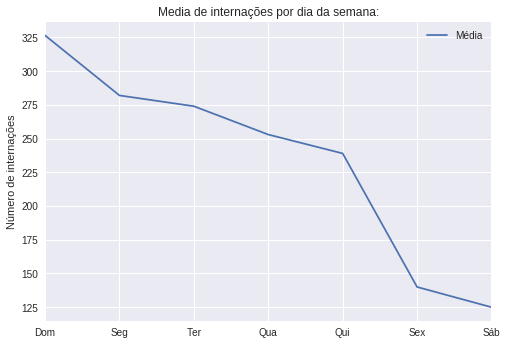

In [22]:
int_by_day.groupby(int_by_day.index.weekday).median().plot(label='Média')

plt.xticks(np.arange(7), ['Dom', 'Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb'])
plt.title('Media de internações por dia da semana:')
plt.ylabel('Número de internações')
plt.legend()
plt.ylim=(0,500)
plt.show()

### Total de internações por dia da semana:
* parece que não muda o padrão nos meses do ano

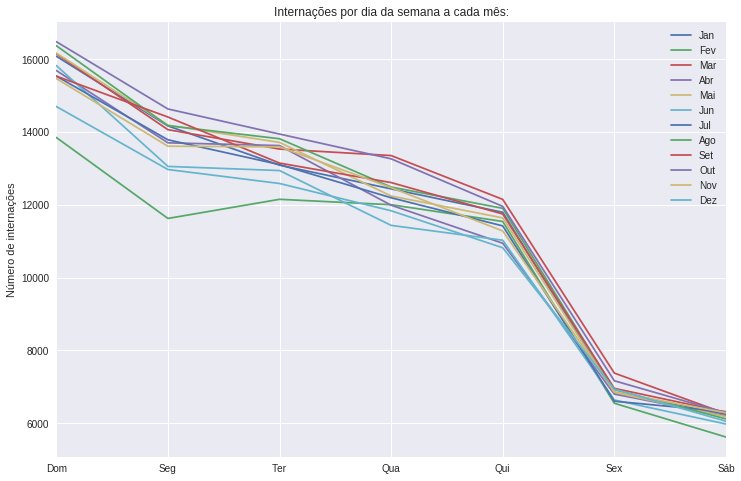

Parece que não muda muito o padrão.


In [23]:
make_weekly_graph(hemato)

### Altas por dia da semana, em cada mês:
* (planejamento de plantões/sobreavisos)
* não é a prevalência, é o número de novas internações (incidência)

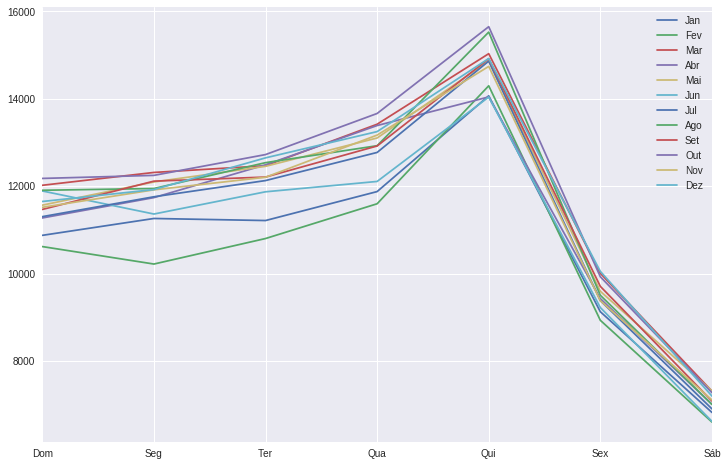

In [24]:
# TODO: fazer a média e o IC, como nas internações
# TODO: fazer prevalência

months = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

pivoted = hemato.pivot_table('N_AIH', index=hemato.DT_SAIDA.dt.weekday, 
                             columns=hemato.DT_SAIDA.dt.month,
                             aggfunc='count')

pivoted.columns.name = None
pivoted.columns = months
pivoted.index.name = None

pivoted.plot(figsize=(12, 8), legend=True)
plt.xticks(np.arange(7), ['Dom', 'Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb'])
plt.show()

### Tempo de internação em todo o período
* Escala logarítmica

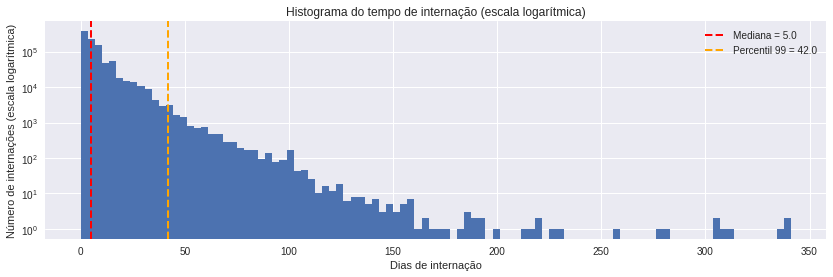

In [25]:
# TODO: fazer um ECDF para confirmar a distribuição exponencial

hemato.DIAS_PERM.hist(bins=100, log=True, figsize=(14, 4))
median = hemato.DIAS_PERM.quantile(.5)
p = hemato.DIAS_PERM.quantile(.99)
plt.axvline(x=median, color='r', linestyle='--', linewidth=2, label='Mediana = {}'.format(median))
plt.axvline(x=p, color='orange', linestyle='--', linewidth=2, label='Percentil 99 = {}'.format(p))

plt.xlabel('Dias de internação')
plt.ylabel('Número de internações (escala logarítmica)')
plt.legend(loc=1)
plt.title('Histograma do tempo de internação (escala logarítmica)')
plt.savefig('images/hist_tempo_internacao.png')
plt.show()

### Resumo de cada CID

In [26]:
describe_by_cid = pd.DataFrame()


mortes = hemato[hemato.MORTE == 1].DIAG_PRINC.map(cid_map).value_counts(ascending=False)
tot = hemato.DIAG_PRINC.map(cid_map).value_counts(ascending=False)
describe_by_cid['Mortality'] = round((mortes / tot).sort_values(ascending=False) * 100, 2)

describe_by_cid = hemato.groupby('DIAG_PRINC').mean()

describe_by_cid.head()

,US_TOT,DIAS_PERM,MORTE,IDADE
DIAG_PRINC,,,,
C811,1484.259277,7.053596,0.032137,28.775882
C812,1718.829590,7.965234,0.042974,31.519556
C813,3762.136475,13.058553,0.064294,34.208955
C819,443.190857,6.162498,0.056011,34.439938
C820,749.088440,8.286963,0.108324,44.571646


In [27]:
sexo_by_cid = pd.DataFrame()
sexo_by_cid["M"] = hemato.query('SEXO == "1"').groupby('DIAG_PRINC').SEXO.count()
sexo_by_cid["F"] = hemato.query('SEXO == "3"').groupby('DIAG_PRINC').SEXO.count()
sexo_by_cid['% M'] = sexo_by_cid.M / (sexo_by_cid.M + sexo_by_cid.F)
sexo_by_cid['% F'] = sexo_by_cid.F / (sexo_by_cid.M + sexo_by_cid.F)

describe_by_cid = describe_by_cid.join(sexo_by_cid[['% M', '% F']])
describe_by_cid.head()

,US_TOT,DIAS_PERM,MORTE,IDADE,% M,% F
DIAG_PRINC,,,,,,
C811,1484.259277,7.053596,0.032137,28.775882,0.520046,0.479954
C812,1718.829590,7.965234,0.042974,31.519556,0.611782,0.388218
C813,3762.136475,13.058553,0.064294,34.208955,0.562572,0.437428
C819,443.190857,6.162498,0.056011,34.439938,0.563585,0.436415
C820,749.088440,8.286963,0.108324,44.571646,0.587609,0.412391


In [30]:
temp = pd.DataFrame()
temp["URG"] = hemato.query('CAR_INT in ["02", "05", "03", "04"]').groupby('DIAG_PRINC').CAR_INT.count()
temp["ELET"] = hemato.query('CAR_INT == "01"').groupby('DIAG_PRINC').CAR_INT.count()
temp['% URG'] = temp.URG / (temp.URG + temp.ELET)
temp['% ELET'] = temp.ELET / (temp.URG + temp.ELET)

describe_by_cid = describe_by_cid.join(temp[['% URG', '% ELET']])
describe_by_cid.head()

,US_TOT,DIAS_PERM,MORTE,IDADE,% M,% F,% URG,% ELET
DIAG_PRINC,,,,,,,,
C811,1484.259277,7.053596,0.032137,28.775882,0.520046,0.479954,0.545169,0.454831
C812,1718.829590,7.965234,0.042974,31.519556,0.611782,0.388218,0.566876,0.433124
C813,3762.136475,13.058553,0.064294,34.208955,0.562572,0.437428,0.584386,0.415614
C819,443.190857,6.162498,0.056011,34.439938,0.563585,0.436415,0.609330,0.390670
C820,749.088440,8.286963,0.108324,44.571646,0.587609,0.412391,0.644622,0.355378


In [28]:
hemato.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 954514 entries, 557 to 5029
Data columns (total 18 columns):
N_AIH         954514 non-null object
UF_ZI         954514 non-null object
DT_INTER      954514 non-null datetime64[ns]
DT_SAIDA      954514 non-null datetime64[ns]
US_TOT        954514 non-null float32
DIAS_PERM     954514 non-null uint16
ANO_CMPT      954514 non-null category
DIAG_PRINC    954514 non-null category
MORTE         954514 non-null uint8
IDADE         954514 non-null uint8
CNES          954514 non-null category
SEXO          954514 non-null category
ETNIA         954514 non-null category
COMPLEX       954514 non-null category
CAR_INT       954514 non-null category
MUNIC_RES     954514 non-null category
MUNIC_MOV     954514 non-null category
NASC          954514 non-null datetime64[ns]
dtypes: category(9), datetime64[ns](3), float32(1), object(2), uint16(1), uint8(2)
memory usage: 62.5+ MB


In [32]:
hemato.MUNIC_MOV == hemato.MUNIC_RES

TypeError: Categoricals can only be compared if 'categories' are the same. Categories are different lengths

### % de óbitos por doença:

In [92]:
mortes = hemato[hemato.MORTE == 1].DIAG_PRINC.map(cid_map).value_counts(ascending=False)
tot = hemato.DIAG_PRINC.map(cid_map).value_counts(ascending=False)
mortalidade_cid = round((mortes / tot).sort_values(ascending=False) * 100, 2)

In [93]:
mortalidade_cid

Embolia pulmonar com menção de cor pulmonale agudo                               21.67
Leucemia aguda de tipo celular não especificado                                  15.54
Doença de Sézary                                                                 15.29
Leucemia plasmocitária                                                           14.68
Leucemia linfocítica crônica                                                     14.57
Anemia refratária com excesso de blastos                                         14.14
Linfoma de células T, periférico                                                 13.16
Doença mieloproliferativa crônica                                                12.51
Leucemia mielomonocítica aguda                                                   12.39
Outros linfomas de células T e os não especificados                              12.37
Leucemia mielóide crônica                                                        12.30
Síndrome hematofagocítica associada à infec

In [94]:
import re

In [95]:
mort_leucemias = pd.DataFrame()
for i in mortalidade_cid.index:
    if re.findall('\S*\weucemia\S*', i):
        mort_leucemias.loc[i, 'avg'] = mortalidade_cid[i]

In [96]:
mort_leucemias

,avg
Leucemia aguda de tipo celular não especificado,15.54
Leucemia plasmocitária,14.68
Leucemia linfocítica crônica,14.57
Leucemia mielomonocítica aguda,12.39
Leucemia mielóide crônica,12.30
Leucemia mielóide aguda,11.17
Leucemia de células T do adulto,10.72
Leucemia megacarioblástica aguda,10.62
Leucemia linfoblástica aguda,3.81


In [253]:
mort_linfoma = pd.DataFrame()
for i in mortalidade_cid.index:
    if re.findall('\S*\winfoma\S*', i):
        mort_linfoma.loc[i, 'avg'] = mortalidade_cid[i]
mort_linfoma

,avg
"Linfoma de células T, periférico",13.16
Outros linfomas de células T e os não especificados,12.37
"Linfoma não-Hodgkin, grandes células, folicular",10.97
"Linfoma não-Hodgkin, pequenas células clivadas, folicular",10.83
"Linfoma não-Hodgkin, folicular, não especificado",10.71
"Linfoma não-Hodgkin difuso, pequenas células (difuso)",10.20
"Linfoma não-Hodgkin, misto, de pequenas e grandes células clivadas, folicular",8.50
"Linfoma não-Hodgkin difuso, grandes células (difuso)",8.02
"Linfoma não-Hodgkin difuso, linfoblástico (difuso)",5.09


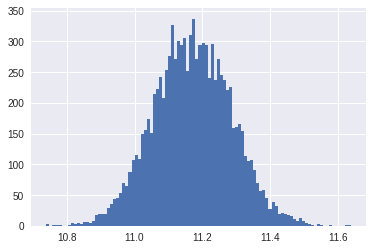

In [105]:
plt.hist(means, bins=int(np.sqrt(len(means))));

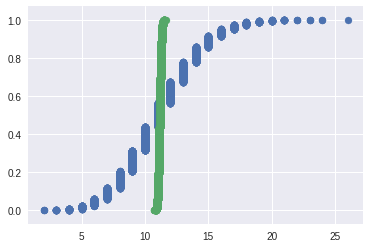

In [101]:
ecdf_bootstrap = ECDF(means)

plt.scatter(ecdf.x, ecdf.y);
plt.scatter(ecdf_bootstrap.x, ecdf_bootstrap.y);

## Segmentando por UF:

### Internações totais e percentuais por UFs 

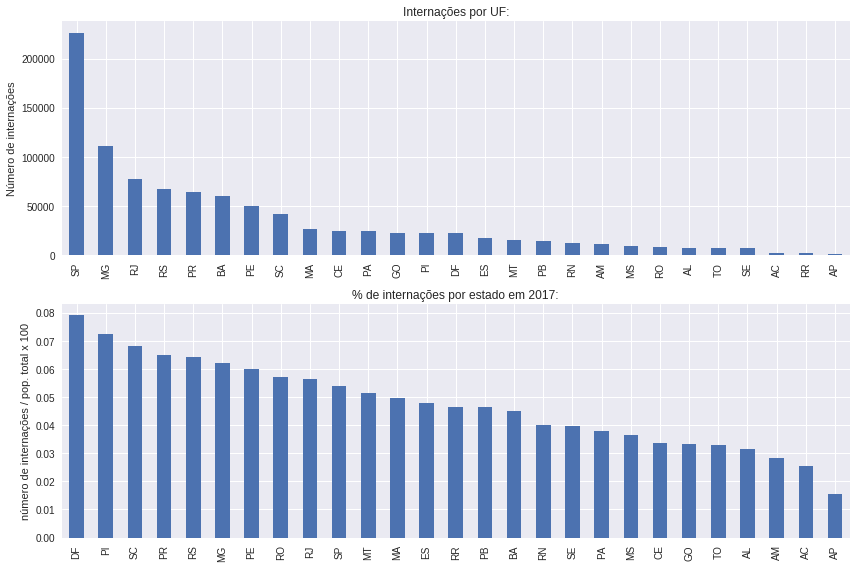

In [24]:
hemato['UF'] = hemato.UF_ZI.map(uf_map)

def plot_internacoes_por_estado():
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    hemato.UF.value_counts().plot(kind='bar', title='Internações por UF:', ax=ax[0])
    ax[0].set_ylabel('Número de internações')

    int_uf_2017 = hemato.groupby(['ANO_CMPT', 'UF']).N_AIH.count()['2017']
    pop_total = pop_df.groupby('SIGLA').sum()
    (int_uf_2017 * 100 / pop_total['2017']).sort_values(ascending=False).plot(kind='bar',
                                                  title='% de internações por estado em 2017:',
                                                  ax=ax[1])
    ax[1].set_ylabel('número de internações / pop. total x 100')
    ax[1].set_xlabel('')

    plt.tight_layout()
    plt.show()
    
plot_internacoes_por_estado()

#### Internações totais no RS por hospital, maiores de 18 anos:

In [25]:
# TODO: fazer outros UFs

def group_int_por_hosp(uf, _map=True, age=18):
    uf = hemato[(hemato.UF == uf) & (hemato.IDADE >= age)]
    if _map:
        mapped = uf.loc[:, 'CNES'].map(cnes_map, na_action='ignore').copy()
        uf.loc[:, 'CNES'] = mapped.copy()
        mapped = uf.loc[:, 'MUNIC_MOV'].map(mun_map,na_action='ignore').copy()
        uf.loc[:, 'MUNIC_MOV'] = mapped.copy()
    group = uf.groupby(['MUNIC_MOV', 'CNES']).SEXO.count().sort_values(ascending=False)
    return group

group = group_int_por_hosp('RS', _map=1, age=18)
group.loc[group > 1000]

MUNIC_MOV       CNES                                                   
Porto Alegre    HOSPITAL DE CLINICAS                                       4998
                HOSPITAL NOSSA SENHORA DA CONCEICAO SA                     3605
Santa Maria     HUSM HOSPITAL UNIVERSITARIO DE SANTA MARIA                 2418
Passo Fundo     HOSPITAL SAO VICENTE DE PAULO                              1856
São Borja       HOSPITAL INFANTIL                                          1458
Porto Alegre    IRMANDADE DA SANTA CASA DE MISERICORDIA DE PORTO ALEGRE    1303
Caxias do Sul   HOSPITAL GERAL                                             1080
Venâncio Aires  HOSPITAL SAO SEBASTIAO MARTIR                              1077
Lajeado         HOSPITAL BRUNO BORN                                        1054
Name: SEXO, dtype: int64

## GHC x HCPA

### Compara HCPA e GHC número de internações por doenças em maiores de 18 anos:

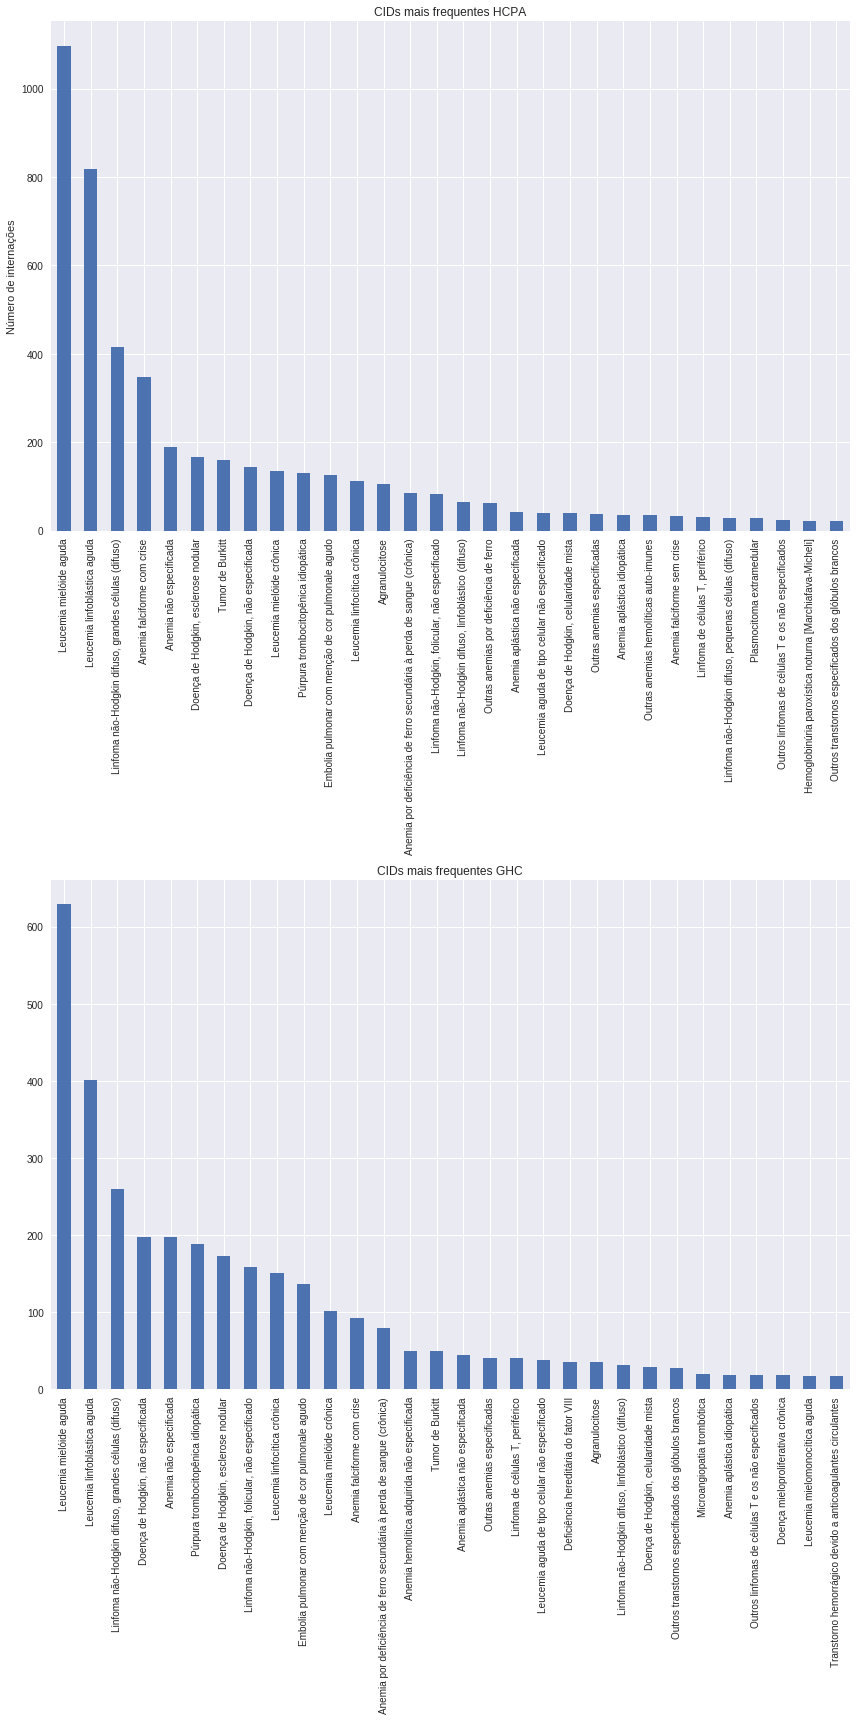

In [26]:
def int_cid_x_cnes(cnes, head=30, age=18):
    return hemato[(hemato.CNES == cnes) & (hemato.IDADE >= age)].DIAG_PRINC.map(cid_map).value_counts().head(head)
    
hcpa = int_cid_x_cnes('2237601')
ghc = int_cid_x_cnes('2237571')

fig, ax = plt.subplots(2, 1, figsize=(12, 24))#, sharey=True)

hcpa.plot(kind='bar', ax=ax[0], title='CIDs mais frequentes HCPA')
ax[0].set_ylabel('Número de internações')
ghc.plot(kind='bar', ax=ax[1], title='CIDs mais frequentes GHC')
plt.tight_layout()
plt.savefig('images/int_cid_hcpa_x_ghc.png')
plt.show()

### Compara GHC e HCPA em internações de menores de 18 anos:

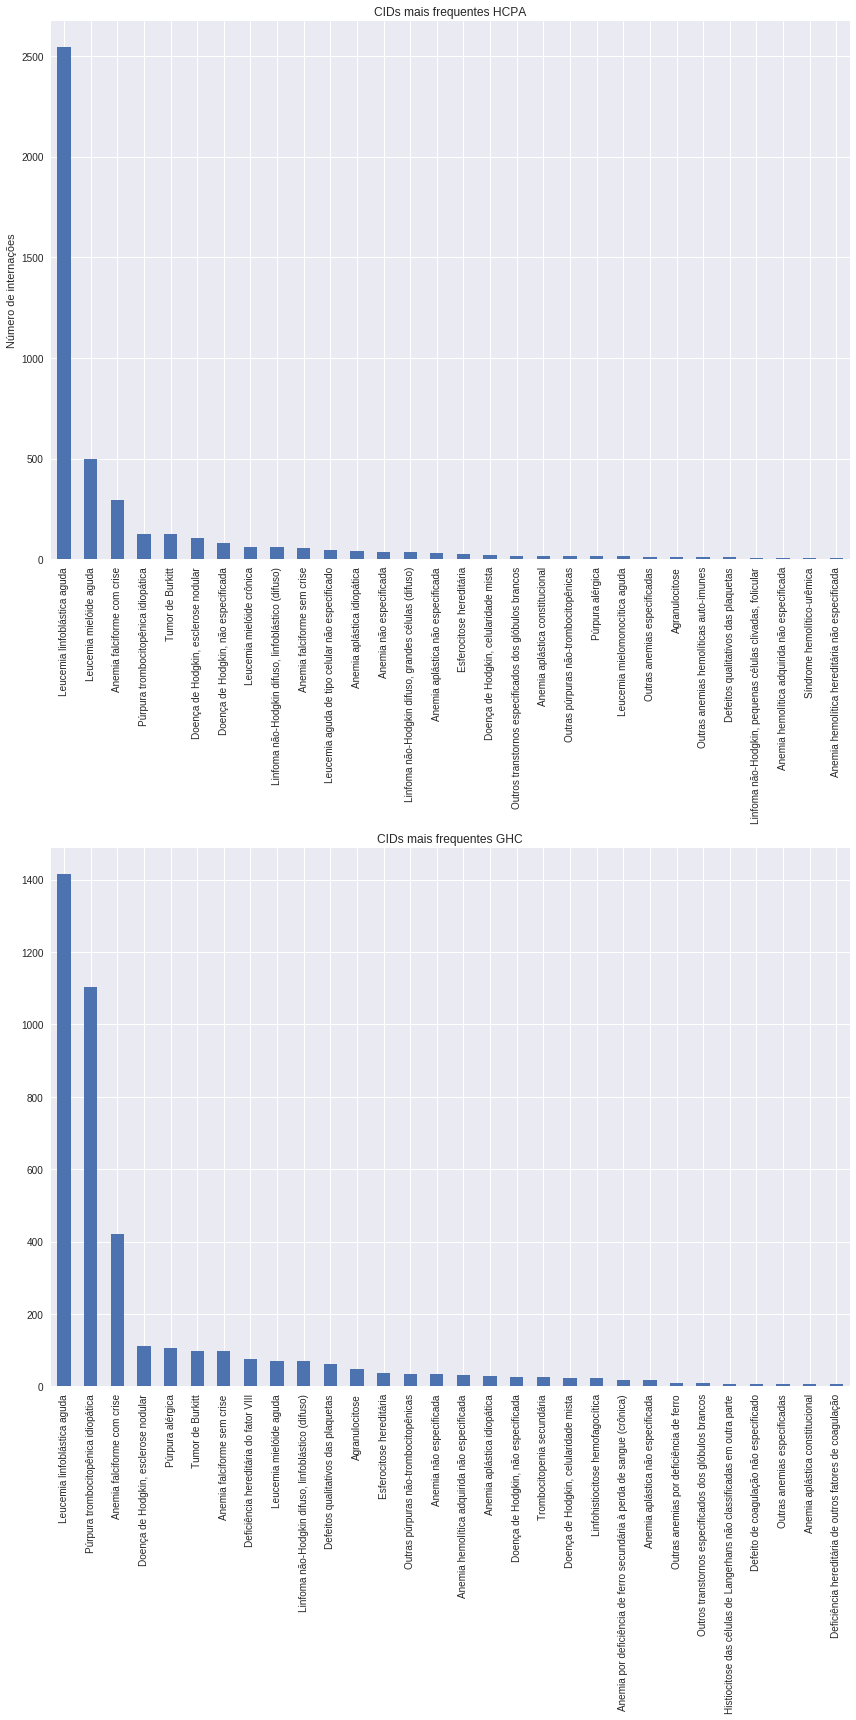

In [30]:
def int_cid_x_cnes(cnes, head=30, age=18):
    return hemato[(hemato.CNES == cnes) & (hemato.IDADE < age)].\
                    DIAG_PRINC.map(cid_map).value_counts().head(head)
    
hcpa = int_cid_x_cnes('2237601')
ghc = int_cid_x_cnes('2237571')

fig, ax = plt.subplots(2, 1, figsize=(12, 24))#, sharey=True)
plt.title('Internações menores de 18 anos')
hcpa.plot(kind='bar', ax=ax[0], title='CIDs mais frequentes HCPA')
ax[0].set_ylabel('Número de internações')
ghc.plot(kind='bar', ax=ax[1], title='CIDs mais frequentes GHC')
plt.tight_layout()
plt.savefig('images/int_cid_hcpa_x_ghc_menores.png')
plt.show()

## Segmentando por idade

### Internações totais no RS, < de 18 anos:

In [31]:
uf = hemato[(hemato.IDADE < 18) & (hemato.UF == 'RS')]
mapped = uf.loc[:, 'CNES'].map(cnes_map, na_action='ignore').copy()
uf.loc[:, 'CNES'] = mapped.copy()
mapped = uf.loc[:, 'MUNIC_MOV'].map(mun_map,na_action='ignore').copy()
uf.loc[:, 'MUNIC_MOV'] = mapped.copy()
uf.groupby(['MUNIC_MOV', 'CNES']).SEXO.count().sort_values(ascending=False)

MUNIC_MOV               CNES                                                   
Porto Alegre            HOSPITAL DE CLINICAS                                       4472
                        HOSPITAL NOSSA SENHORA DA CONCEICAO SA                     4113
Santa Maria             HUSM HOSPITAL UNIVERSITARIO DE SANTA MARIA                 2500
Porto Alegre            IRMANDADE DA SANTA CASA DE MISERICORDIA DE PORTO ALEGRE    1983
Passo Fundo             HOSPITAL SAO VICENTE DE PAULO                              1170
Caxias do Sul           HOSPITAL GERAL                                              561
Porto Alegre            HOSPITAL SAO LUCAS DA PUCRS                                 518
Pelotas                 HOSPITAL ESCOLA DA UNIVERSIDADE FEDERAL DE PELOTAS          206
São Borja               HOSPITAL INFANTIL                                           189
Passo Fundo             HOSPITAL DE CLINICAS                                        180
Rio Grande              FAHERG          

## Machine Learning

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer, StandardScaler, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans

from tempfile import mkdtemp
from shutil import rmtree

### Clustering

#### Finding the optimal value of n_clusters using just a sample

In [27]:
X = hemato.drop(['N_AIH', 'DT_INTER', 'DT_SAIDA', 'NASC'], axis=1).sample(50000)

In [26]:
dum = pd.get_dummies(X, sparse=True)

In [28]:
dum.shape

(50000, 65496)

In [34]:
X.shape
ohe = OneHotEncoder()
enc = ohe.fit_transform(X)

ValueError: Input contains NaN

In [28]:

def make_cluster_graph(n):
    steps = [
        ('ohe', OneHotEncoder()),
        ('scale', MaxAbsScaler()),
    ]

    pipe = Pipeline(steps)
    X_pipe = pipe.fit_transform(X)

    mini = MiniBatchKMeans(n)
    mini.fit(X_pipe)

    labels = mini.predict(X_pipe)
    return mini.inertia_

In [29]:
inertias = []
_range = range(2, 101)

for n in _range:
    z = make_cluster_graph(n)
    inertias.append(z)

ValueError: Input contains NaN

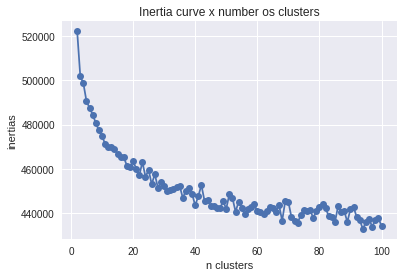

In [38]:
plt.plot(_range, inertias, '-o')
plt.ylabel('inertias')
plt.xlabel('n clusters')
plt.title('Inertia curve x number os clusters')
plt.show()

# The optimal number of clusters is about 45

#### MiniBatchKMeans with 45 clusters using all dataset

In [41]:
X = hemato.drop(['DT_INTER', 'DT_SAIDA'], axis=1)

n = 45 # optimal value
steps = [
    ('ohe', OneHotEncoder()),
    ('scale', MaxAbsScaler()),
    ('mini', MiniBatchKMeans(n))
]

pipe = Pipeline(steps)
labels = pipe.fit_predict(X)

In [58]:
from sklearn.random_projection import SparseRandomProjection

steps = [
    ('ohe', OneHotEncoder()),
    ('scale', MaxAbsScaler()),
    ('dim_red', SparseRandomProjection()),
    ('mini', MiniBatchKMeans(n))
]

pipe = Pipeline(steps) #, memory=cachedir)
labels_2 = pipe.fit_predict(X)

In [68]:
l1 = []
l2 = []
for l in range(45):
    l1.append(len(hemato[labels == l]))
    l2.append(len(hemato[labels_2 == l]))
    
df_len = pd.DataFrame({'Labels': l1, 'Labels_2': l2})

In [69]:
df_len

,Labels,Labels_2
0,29314,29
1,35779,37956
2,107541,31118
3,45235,11264
4,51941,22513
5,62225,58787
6,21128,41256
7,18658,1723
8,43656,28231
9,16642,49594


In [79]:
l1 = []
l2 = []
for l in range(45):
    l1.append(hemato[labels == l].DIAG_PRINC.value_counts())
    l2.append(hemato[labels_2 == l].DIAG_PRINC.value_counts())
    
df_diag_1 = pd.concat(l1, axis=1)
df_diag_1.columns = range(45)

df_diag_2 = pd.concat(l2, axis=1)
df_diag_2.columns = range(45)

In [80]:
df_diag_1.T.describe()

,C811,C812,C813,C819,C820,C821,C822,C829,C830,C833,C835,C837,C840,C841,C844,C845,C880,C901,C902,C910,C911,C915,C920,C921,C925,C942,C950,D339,D45,D460,D461,D462,D463,D464,D471,D472,D473,D500,D508,D510,D518,D520,D521,D550,D551,D561,D563,D568,D569,D570,...,D595,D599,D600,D601,D610,D611,D613,D619,D641,D642,D648,D649,D65,D66,D67,D680,D681,D682,D683,D684,D688,D689,D690,D691,D692,D693,D695,D698,D70,D721,D728,D730,D731,D732,D750,D751,D752,D760,D761,D762,D890,D891,E831,I260,I780,M250,M311,M329,M362,R71
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,...,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.00000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,181.244444,40.555556,17.022222,394.866667,52.933333,16.088889,31.711111,183.022222,155.422222,421.022222,89.555556,193.488889,16.355556,3.000000,31.955556,69.044444,9.111111,17.111111,16.888889,3238.422222,187.644444,13.022222,1465.511111,227.955556,26.200000,5.777778,98.800000,14.133333,10.866667,9.733333,2.577778,13.488889,20.022222,61.355556,33.844444,12.933333,11.355556,663.888889,359.488889,19.511111,29.311111,8.888889,3.466667,92.600000,12.155556,9.777778,0.511111,4.355556,12.733333,1440.355556,...,7.311111,577.155556,112.666667,5.533333,72.200000,14.444444,78.688889,648.533333,5.444444,4.955556,619.800000,3075.200000,62.466667,149.244444,30.777778,13.222222,1.800000,8.488889,54.044444,7.244444,72.733333,138.333333,76.244444,66.866667,68.022222,493.266667,22.088889,72.266667,297.777778,7.777778,77.755556,2.755556,51.80000,35.044444,4.133333,19.822222,13.133333,10.800000,5.533333,5.711111,0.177778,0.288889,12.822222,479.111111,0.822222,4.111111,62.044444,143.022222,1.800000,0.444444
std,272.679645,60.305116,28.750090,544.283750,77.329696,25.875420,44.420830,259.701970,218.371503,570.581222,137.940790,296.492267,25.436334,5.616534,56.762646,132.091214,14.233798,27.322337,25.746334,5000.526397,325.373642,24.775803,2098.126909,312.762323,49.979359,8.519733,171.666643,21.688497,20.216555,18.812955,5.594189,31.603813,45.750057,124.549215,65.906599,37.156548,16.412517,1297.687808,757.445756,40.420867,55.122517,18.717059,6.874194,170.572219,23.906024,18.527484,1.120516,8.975106,24.679215,2774.992073,...,13.810112,1335.763468,242.758297,12.333620,119.218211,31.606642,114.685107,1353.835236,16.508339,12.567917,1184.181509,9954.082768,136.692355,364.906536,82.822068,22.076200,4.197402,14.539323,101.155810,13.648436,133.347018,272.349041,152.931232,137.220228,136.860328,943.407855,39.813670,133.387406,554.172761,13.326134,135.668740,5.152914,115.10047,77.611490,7.895914,50.689020,24.381998,19.017456,11.050710,10.807452,0.441531,0.869227,29.121445,997.004519,1.599558,10.057160,113.407142,283.096553,4.490394,1.216469
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [81]:
df_diag_2.T.describe()

,C811,C812,C813,C819,C820,C821,C822,C829,C830,C833,C835,C837,C840,C841,C844,C845,C880,C901,C902,C910,C911,C915,C920,C921,C925,C942,C950,D339,D45,D460,D461,D462,D463,D464,D471,D472,D473,D500,D508,D510,D518,D520,D521,D550,D551,D561,D563,D568,D569,D570,...,D595,D599,D600,D601,D610,D611,D613,D619,D641,D642,D648,D649,D65,D66,D67,D680,D681,D682,D683,D684,D688,D689,D690,D691,D692,D693,D695,D698,D70,D721,D728,D730,D731,D732,D750,D751,D752,D760,D761,D762,D890,D891,E831,I260,I780,M250,M311,M329,M362,R71
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,...,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,181.244444,40.555556,17.022222,394.866667,52.933333,16.088889,31.711111,183.022222,155.422222,421.022222,89.555556,193.488889,16.355556,3.000000,31.955556,69.044444,9.111111,17.111111,16.888889,3238.422222,187.644444,13.022222,1465.511111,227.955556,26.200000,5.777778,98.800000,14.133333,10.866667,9.733333,2.577778,13.488889,20.022222,61.355556,33.844444,12.933333,11.355556,663.888889,359.488889,19.511111,29.311111,8.888889,3.466667,92.600000,12.155556,9.777778,0.511111,4.355556,12.733333,1440.355556,...,7.311111,577.155556,112.666667,5.533333,72.200000,14.444444,78.688889,648.533333,5.444444,4.955556,619.800000,3075.200000,62.466667,149.244444,30.777778,13.222222,1.800000,8.488889,54.044444,7.244444,72.733333,138.333333,76.244444,66.866667,68.022222,493.266667,22.088889,72.266667,297.777778,7.777778,77.755556,2.755556,51.800000,35.044444,4.133333,19.822222,13.133333,10.800000,5.533333,5.711111,0.177778,0.288889,12.822222,479.111111,0.822222,4.111111,62.044444,143.022222,1.800000,0.444444
std,207.638032,49.738204,23.492251,380.582663,53.707711,17.884506,31.865215,183.402128,169.150752,427.341065,96.581702,201.949884,21.975354,5.183014,36.844239,86.836303,11.283983,18.559759,18.487369,4211.942736,197.206301,19.000585,1403.539481,212.231965,37.361623,7.994000,102.521306,16.002273,14.509558,14.840669,4.702460,28.413843,36.800129,81.907974,41.556618,26.171984,13.026469,1112.504570,1101.625341,34.841604,54.022227,15.758435,6.344647,142.735037,21.906781,17.347896,1.198905,6.023271,19.758082,2190.942420,...,10.328298,1265.625662,168.972833,9.408893,95.533335,20.905149,80.574026,1000.751027,8.630168,8.442198,872.762896,7823.541547,137.905040,250.642099,50.905835,17.884591,3.093982,12.101131,78.849960,10.898614,105.798995,206.448871,123.558811,108.733745,111.421699,776.101575,28.042842,125.630483,446.831313,10.144163,97.636421,4.200409,67.595925,46.178486,6.214353,29.406469,19.934666,15.142655,8.256127,8.812755,0.490310,0.815259,22.391444,659.132047,1.192570,7.468790,92.036790,291.696253,3.401871,0.692675
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [70]:
hemato.columns

Index(['N_AIH', 'DT_INTER', 'DT_SAIDA', 'US_TOT', 'DIAS_PERM', 'ANO_CMPT',
       'DIAG_PRINC', 'MORTE', 'IDADE', 'CNES', 'UF', 'SEXO', 'ETNIA',
       'COMPLEX', 'CAR_INT', 'MUNIC_RES', 'MUNIC_MOV'],
      dtype='object')

In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='most_frequent')
clf.fit(X, y)
dummy = clf.predict(X)

print('Dummy accuracy: {}'.format(accuracy_score(y, dummy)))

In [ ]:
# Searching for correlations using pandas.corr
# TODO: Is this corr the same each year?

data = pd.DataFrame(X_scaled, columns=hemato.columns).drop(['N_AIH', 'DT_INTER', 'DT_SAIDA'], axis=1)
corr = data.corr('spearman')
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)

ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)

for i in range(len(corr.index)):
    for j in range(len(corr.columns)):
        text = ax.text(j, i, '{} %'.format(int(corr.iloc[i, j] ** 2 * 100)),
                       ha="center", va="center", color="k")
plt.show()

# o percentual se refere ao quanto a variação do eixo y é atribuida ao x

In [ ]:
from scipy.stats import pearsonr, spearmanr
p = pearsonr(X_scaled[0], X_scaled[1])
s = spearmanr(X_scaled[0], X_scaled[1])

## Todo:

X DIAG_PRINC separar CIDs de hemato antes de juntar os arquivos.

X Por que o N_AIH tem numeros repetidos? Interna várias vezes com o mesmo registro? Erro?

Identificar a cidade pelo CEP e verificar quem tem um endereço e interna em outra cidade/estado.

Posso usar o MUNIC_RES pra fazer o que escrevi acima.

UTI_MES_TO e UTI_INT_TO pode dizer quais CIDs são mais graves. Se o percentual de internações graves aumentou. Posso relacionar se morrem muito na UTI ou se salvam muito.

Hemato ganha muita diaria de acompanhante? DIAR_ACOM

Quais CIDs ficam mais tempo internado? QT_DIARIAS Algum estado demora mais no tratamento, comparando mesmas doenças? Isso se reflete no resultado do tto?

----------
##### Financeiro

VAL_SH (hosp) VAL_SP (profissional) VAL_TOT VAL_UTI US_TOT Quanto paga cada internação de hemato? Qual paga mais?

FINANC A grana vem de onde?

VAL_SADT, VAL_ACOMP, VAL_SANGUE está zerado???

90 VAL_SH_FED numeric (10, 2) Valor do complemento federal de serviços hospitalares. Está
 incluído no valor total da AIH.

91 VAL_SP_FED numeric (10, 2) Valor do complemento federal de serviços profissionais. Está
 incluído no valor total da AIH.

92 VAL_SH_GES numeric (10, 2) Valor do complemento do gestor (estadual ou municipal) de
 serviços hospitalares. Está incluído no valor total da AIH.

93 VAL_SP_GES numeric (10, 2) Valor do complemento do gestor (estadual ou municipal) de
 serviços profissionais. Está incluído no valor total da AIH.
 
VAL_UCI O que é UCI???

-----------

DT_INTER DT_SAIDA DIAS_PERM Datas de int e alta conferem com as diárias? Há datas de anos/meses anteriores que contaram nesta competencia (atraso de envio?)

Não incluí a natureza jurídica e a gestão porque é certo que vai ter mais internações nos tipos de lugares que existem, seja por imposição legal ou incentivo fiscal. Não quer dizer que sejam mais importantes.

MUNIC_MOV Municipio do estabelecimento. Este dado é confiável? Se for, posso usar pra comparar com o MUNIC_RES.

COD_IDADE IDADE Perfil de idade dos pacientes atendidos.

NACIONAL Nacionalidade do paciente

CAR_INT Vem muito pct hemato de emergência?

CBOR NUM_FILHOS INSTRU VINCPREV Acho importante pra comparar por regiões e por tempo, mas tenho dúvidas da veracidade dos dados.

RACA_COR ETNIA Comparar as duas classificações.

Qual a prevalência de pacientes internados? (Como calcular a prevalencia?)